<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Basics on Neural Latent SDE
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Biblio
</div>

Neural ODEs:

**Neural ODEs (https://arxiv.org/abs/1806.07366) (2019)** : introduction of the Neural ODE as the continuous-time limit of a ResNet stack. Presentation of the use of the adjoint sensitivity method. Seminal paper for Neural ODE.

**Latent ODEs for Irregularly-Sampled Time Series (https://arxiv.org/abs/1907.03907) (2019)** : Evolution of the Neural ODE model towards a Neural ODE RNN model, where the approximate posterior is built with a RNN on past observations.

Neural SDEs:

**SDE Matching: Scalable and Simulation-Free Training of Latent Stochastic Differential Equations (https://arxiv.org/abs/2502.02472 , 2025)** : good background section (#2) to explain Neural SDE. Propose a new method SDE matching, inspired by score and flow matching, vs the adjoint sensivity method. SDE matching is claimed to be more efficient to compute gradients and train latent SDEs.

**Scalable Gradients for Stochastic Differential Equations (https://arxiv.org/abs/2001.01328) (2020)** : generalization of the adjoint sensitivity method to SDEs. Combination with gradient-based stochastic variational inference for infinite-dimension VAEs.

**Neural SDEs (https://www.researchgate.net/publication/333418188_Neural_Stochastic_Differential_Equations) (2019)** : link between infinitely deep residual networks and solutions to stochastic differential equations

**Stable Neural SDEs in analyzing irregular time series data (https://arxiv.org/abs/2402.14989) (2025)** : points to the necessity of careful design of the drift and diffusion neural nets in latent SDEs. Introduces three latent SDEs models with performance guarantees.

**Generative Modeling of Neural Dynamics via Latent Stochastic Differential Equations (https://arxiv.org/abs/2412.12112) (2024)** : application of neural SDEs to a biological use case (brain activity). Details the model, architecture, ELBO/loss computation. Takes into account inputs/commands in the model. 

General/Misc:

**Efﬁcient gradient computation for dynamical models (https://www.fil.ion.ucl.ac.uk/~wpenny/publications/efficient_revised.pdf) (2014)** : summary of finite difference method, forward sensitivity method, adjoint sensitivity method, to compute gradients of a functional cost function. Applies to Neural ODEs training.

**Cyclical Annealing Schedule: A Simple Approach to Mitigating KL Vanishing (https://arxiv.org/abs/1903.10145) (2019)** : explanation of the posterior collapse/KL vanishing problem, introduces different KL annealing schedules for VAE training.


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Code : torchsde library by Google Research
</div>

https://github.com/google-research/torchsde

[1] Xuechen Li, Ting-Kam Leonard Wong, Ricky T. Q. Chen, David Duvenaud. "Scalable Gradients for Stochastic Differential Equations". International Conference on Artificial Intelligence and Statistics. 2020. [arXiv]

[2] Patrick Kidger, James Foster, Xuechen Li, Harald Oberhauser, Terry Lyons. "Neural SDEs as Infinite-Dimensional GANs". International Conference on Machine Learning 2021. [arXiv]

[3] Patrick Kidger, James Foster, Xuechen Li, Terry Lyons. "Efficient and Accurate Gradients for Neural SDEs". 2021. [arXiv]

[4] Patrick Kidger, James Morrill, James Foster, Terry Lyons, "Neural Controlled Differential Equations for Irregular Time Series". Neural Information Processing Systems 2020. [arXiv]



<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Basic manipulations of the torchsde library
</div>

See also https://github.com/google-research/torchsde/blob/master/examples/demo.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchsde
from torchdiffeq import odeint, odeint_adjoint

# from mpl_toolkits.mplot3d import Axes3D
import timeit

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Creating a SDE model, sampling paths
</div>

In [4]:
# create an Ornstein Uhlenbeck SDE model:
# dX_t = theta * (mu - X_t) dt + sigma dW_t
# theta, mu, sigma scalar parameters
# W_t is a standard 1D Brownian motion

# SDE are instantiated as subclasses of nn.Module

class OUSDE(nn.Module):
    def __init__(self, theta, mu, sigma):
        
        # noise type can take 4 values : "diagonal", "general", "additive", "scalar"
        # here we use "diagonal" : the diffusion function g(t,y) is an element wise function,
        # its output has the same shape as y, ie (batch_size, state_size)
        
        # sde_type can be "ito" or "stratonovich"
        # we use "ito" here. The available methods for computation are Euler(-Maruyama), Milstein, SRK.
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        # we register the parameters so we can save them. But we will not train them.
        self.register_buffer("theta", torch.tensor(theta))
        self.register_buffer("mu", torch.tensor(mu))
        self.register_buffer("sigma", torch.tensor(sigma))

    # DRIFT FUNCTION
    # inputs are:
    # - t : a tensor of shape (1,) representing the time stamps
    # - y : a tensor of shape (batch_size, state_size) representing the current state
    # outputs:
    # - a tensor of shape (batch_size, state_size) representing the drift at time t and state y
    # note : the functions f and g must be able to handle inputs of shape (batch_size, state_size)
    # for any batch_size >= 1
    def f(self, t, y):
        return self.theta * (self.mu - y)
    
    # DIFFUSION FUNCTION
    # inputs are:
    # - t : a tensor of shape (1,) representing the time stamps
    # - y : a tensor of shape (batch_size, state_size) representing the current state
    # outputs:
    # - a tensor of shape (batch_size, state_size) representing the diffusion at time t and state y
    # (NB : generally, the output of g is of shape (batch_size, state_size, brownian_size) when noise_type is "general")
    def g(self, t, y):
        return self.sigma * torch.ones_like(y)
    
model = OUSDE(theta=2.0, mu=0.5, sigma=0.1).to(device)

In [5]:
N_POINTS = 50 # number of points in each path
N_PATHS = 10  # number of paths to sample

t_start = 0.0
t_end = 10.0

ts = torch.linspace(t_start, t_end, N_POINTS).to(device)  # time stamps where we want the solution, between 0 and 1
print(f"Time stamps shape : {ts.shape}")  # shape (N_POINTS,)
y_start = 0.25  # initial condition
y0 = torch.full((N_PATHS, 1), y_start).to(device)  # initial condition 0.25, shape (batch_size=N_PATHS, state_size=1)
print(f"Initial condition shape : {y0.shape}")  # shape (N_PATHS, 1)

# now, we call sdeint to solve the SDE
# NB : we can use the adjoint method by calling sdeint_adjoint instead of sdeint
# method can be "euler", "milstein", "srk" for sde_type="ito"
# dt is the step size used by the solver (smaller dt -> more accurate but slower). By default, dt=1e-3

with torch.no_grad():  # we don't need gradients for this demo
    ys = torchsde.sdeint(model, y0, ts, method="euler", dt=1e-3)  # shape (N_POINTS, N_PATHS, 1)
print(f"Computed solution samples : {ys.size()}")

Time stamps shape : torch.Size([50])
Initial condition shape : torch.Size([10, 1])
Computed solution samples : torch.Size([50, 10, 1])


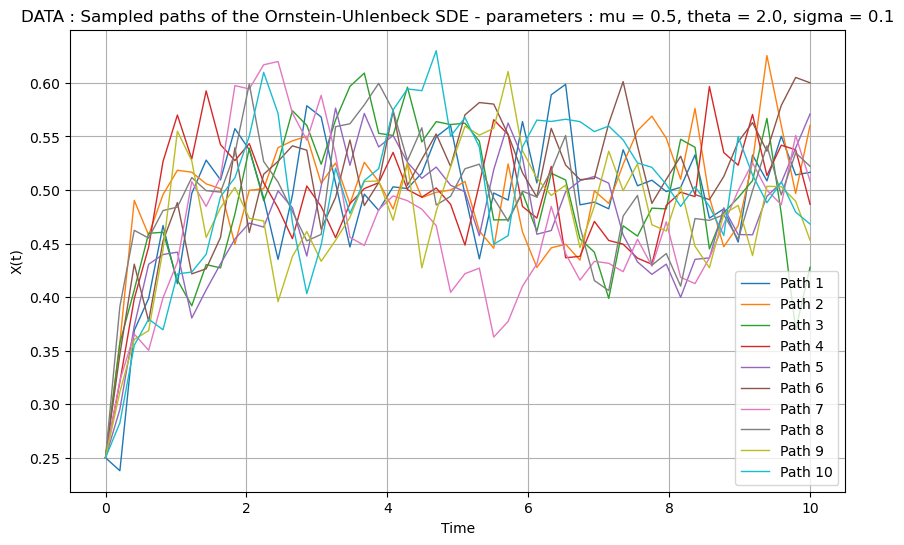

In [6]:
def plot_ousde_samples(ts, ys, model):
    """
    Utility functions to plot the sampled SDE solutions
    """
    fig, ax = plt.subplots(figsize=(10,6))
    n_points = ts.size()[0]
    n_paths = ys.size()[1]
    
    for i, y in enumerate(ys.permute(1,0,2)):  # iterate over paths
        ax.plot(ts.detach().cpu().numpy(), y.detach().cpu().numpy(), lw=1, alpha=1.0, label=f'Path {i+1}' if i<10 else None)  # plot each path
        
    ax.set_title(f"DATA : Sampled paths of the Ornstein-Uhlenbeck SDE - parameters : mu = {model.mu.item():.1f}, theta = {model.theta.item():.1f}, sigma = {model.sigma.item():.1f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.legend()
    ax.grid()
        
    return fig, ax

fig, ax = plot_ousde_samples(ts, ys, model)
plt.show()

In [7]:
# data
data = ys.permute(1,0,2).detach()  # shape (N_PATHS, N_POINTS, 1)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Toy 1 : learning a O.U. model from the data
</div>

NB - yes this is an ugly way to learn parameters of an O.U. process. It is just to demonstrate a basic use of the torchsde SDE model class.

In [8]:
class Toy_OU_SDE(nn.Module):
    def __init__(self):
        
        # we keep "diagonal" noise type
        
        # sde_type can be "ito" or "stratonovich"
        # we use "ito" here. The available methods for computation are Euler(-Maruyama), Milstein, SRK.
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        # here, we want to learn the parameters theta, mu, sigma
        self.theta = nn.Parameter(torch.tensor(1.0))  # initial guess
        self.mu = nn.Parameter(torch.tensor(1.0))     # initial guess
        self.sigma = nn.Parameter(torch.tensor(1.0))  # initial guess

    # DRIFT FUNCTION - same signature as above
    def f(self, t, y):
        return self.theta * (self.mu - y)
    
    # DIFFUSION FUNCTION - same signature as above
    def g(self, t, y):
        return self.sigma**2 * torch.ones_like(y)

# instantiate model
model_ou_1 = Toy_OU_SDE().to(device)

Computed solution samples : torch.Size([50, 10, 1])


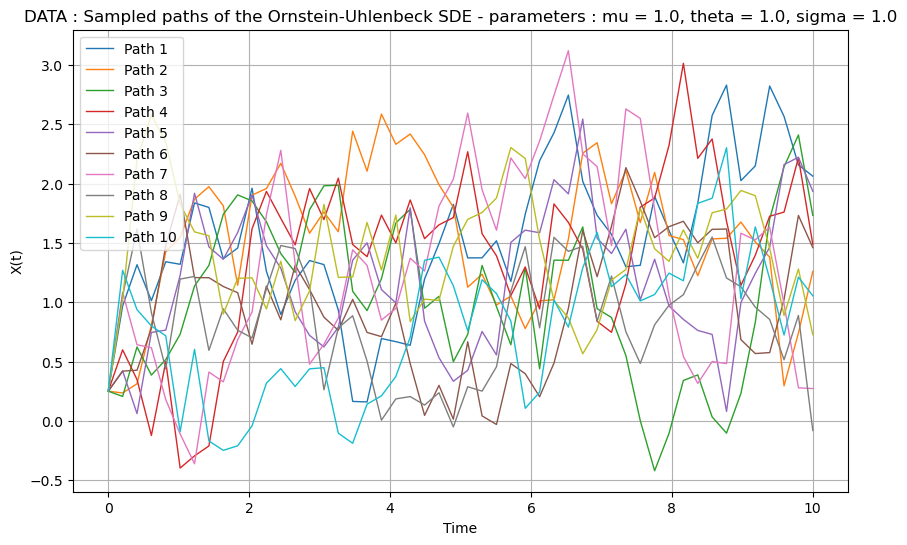

In [9]:
preds = torchsde.sdeint(model_ou_1, y0, ts, method="euler", dt=1e-3)  # shape (N_POINTS, N_PATHS, 1)
print(f"Computed solution samples : {preds.size()}")

fig, ax = plot_ousde_samples(ts, preds, model_ou_1)
plt.show()

In [10]:
def plot_comparison(learned_model, t_start=t_start, t_end=t_end, N_SAMPLES=5, device=device, gt_model=model):
    """
    Utility function to plot comparison between ground truth model and learned model
    """

    bm = torchsde.BrownianInterval(t_start, t_end, size=(N_SAMPLES, 1), device=device) # instantiate N_SAMPLES independent Brownian motions of dimension 1
    bm_increments = torch.stack([bm(t0,t1) for t0,t1 in zip(ts[:-1], ts[1:])])  # sample N_POINTS-1 increments for each BM : shape (N_POINTS-1, N_SAMPLES, 1)
    bm_queries = torch.cat([torch.zeros(1, N_SAMPLES, 1, device=device), torch.cumsum(bm_increments, dim=0)])  # add independent increments to sample Brownian motions : shape (N_POINTS, N_SAMPLES, 1)

    y_start = 0.1
    y0s = torch.full((N_SAMPLES, 1), y_start).to(device)  # initial condition 0.1, shape (batch_size=N_SAMPLES, state_size=1)

    with torch.no_grad():
        ys_true = torchsde.sdeint(gt_model, y0s, ts, method="euler", dt=1e-3, bm=bm)  # shape (N_POINTS, N_SAMPLES, 1)
        ys_learned = torchsde.sdeint(learned_model, y0s, ts, method="euler", dt=1e-3, bm=bm)  # shape (N_POINTS, N_SAMPLES, 1)

    fig, ax = plt.subplots(nrows=1, ncols=N_SAMPLES, figsize=(6*N_SAMPLES,6))

    for i in range(N_SAMPLES):
        ax[i].plot(ts.detach().cpu().numpy(), ys_true[:,i,:].detach().cpu().numpy(), lw=2, alpha=1.0, label='Ground truth', color='blue')
        ax[i].plot(ts.detach().cpu().numpy(), ys_learned[:,i,:].detach().cpu().numpy(), lw=2, alpha=1.0, label='Model', color='orange')
        ax[i].set_title(f"Sampled paths - Sample {i+1}")
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("X(t)")
        ax[i].legend()
        ax[i].grid()
        
    return fig, ax

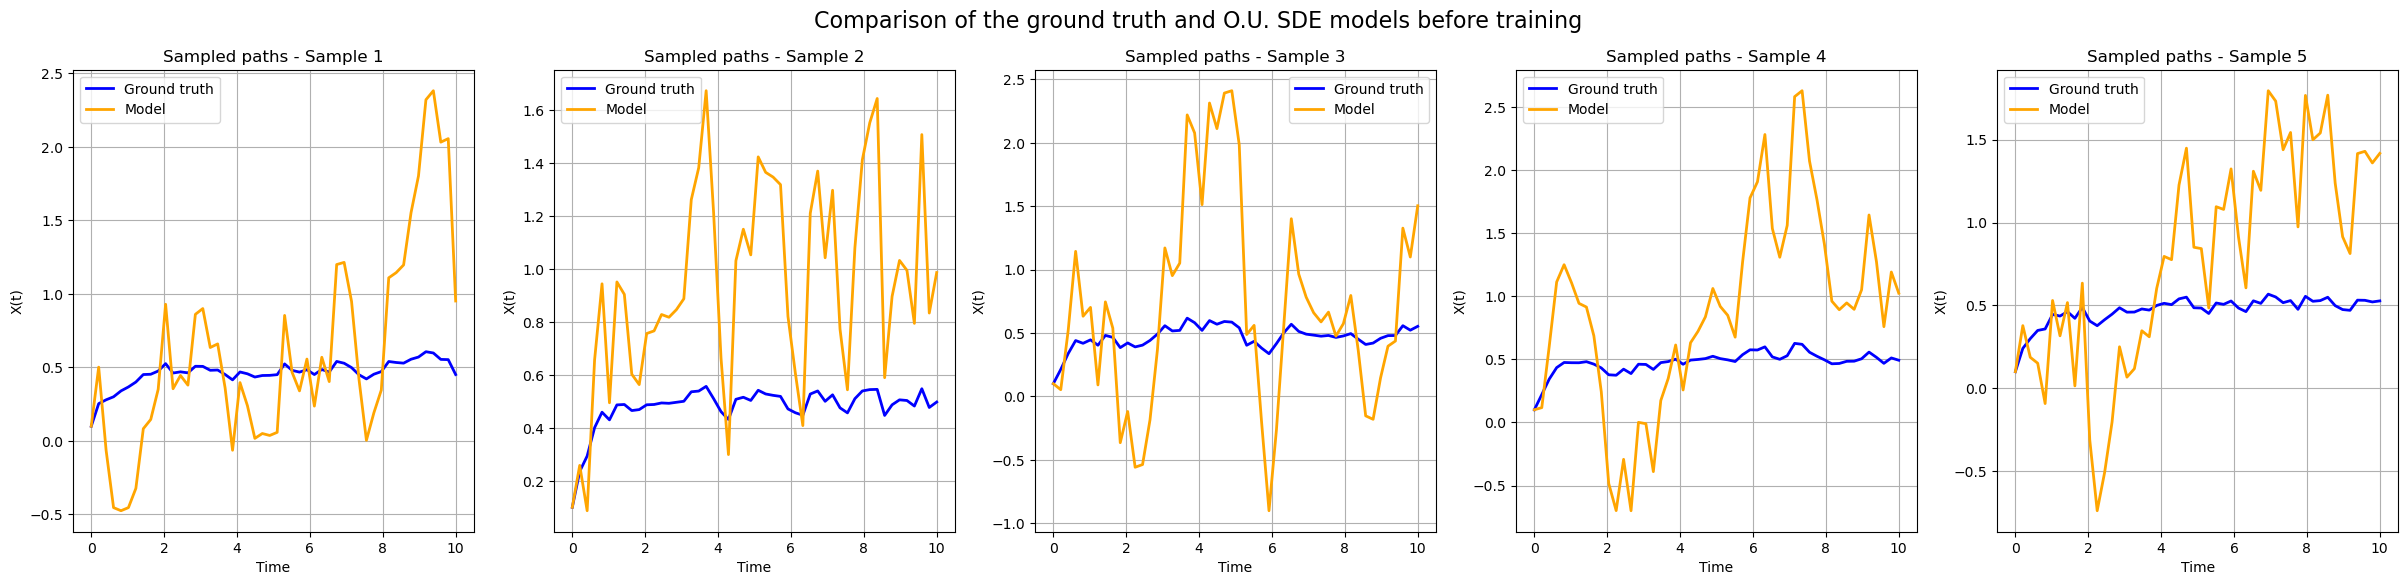

In [11]:
# avant training
fig, ax = plot_comparison(model_ou_1)
fig.suptitle("Comparison of the ground truth and O.U. SDE models before training", fontsize=16)
plt.show()

In [12]:
# training loop parameters
learning_rate = 1e-2

optimizer = torch.optim.Adam(
    list(model_ou_1.parameters()), 
    lr=learning_rate
)

# -------------------------------------------------------
# --- N EPOCHS for all training loops
# -------------------------------------------------------
N_EPOCHS = 250

thetas = []
mus = []
sigmas = []
losses = []

for epoch in range(N_EPOCHS):
    # compute SDE and sample N_PATHS
    preds = torchsde.sdeint(model_ou_1, y0, ts, method="euler", dt=1e-3)  # shape (N_POINTS, N_PATHS, 1)
    # compute average L2 loss between data paths and sampled paths
    mse = (data - preds.permute(1,0,2))**2
    loss = mse.mean()
    # train
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # record and report out
    losses.append(loss.item())
    m = model_ou_1.mu.item()
    s = torch.sqrt(model_ou_1.sigma).item()
    t = model_ou_1.theta.item()
    mus.append(m)
    sigmas.append(s)
    thetas.append(t)
    print(f"Epoch {epoch+1:<3} - {N_EPOCHS:<3} - loss = {loss.item():.3e} - parametres : theta = {t:.3f}, mu = {m:.3f}, sigma = {s:.3f}")

Epoch 1   - 250 - loss = 5.517e-01 - parametres : theta = 1.010, mu = 0.990, sigma = 0.995
Epoch 2   - 250 - loss = 6.133e-01 - parametres : theta = 1.020, mu = 0.980, sigma = 0.990
Epoch 3   - 250 - loss = 6.207e-01 - parametres : theta = 1.030, mu = 0.970, sigma = 0.985
Epoch 4   - 250 - loss = 5.288e-01 - parametres : theta = 1.040, mu = 0.960, sigma = 0.980
Epoch 5   - 250 - loss = 4.691e-01 - parametres : theta = 1.049, mu = 0.950, sigma = 0.975
Epoch 6   - 250 - loss = 5.591e-01 - parametres : theta = 1.059, mu = 0.940, sigma = 0.970
Epoch 7   - 250 - loss = 5.398e-01 - parametres : theta = 1.069, mu = 0.930, sigma = 0.965
Epoch 8   - 250 - loss = 4.062e-01 - parametres : theta = 1.078, mu = 0.920, sigma = 0.959
Epoch 9   - 250 - loss = 5.122e-01 - parametres : theta = 1.088, mu = 0.910, sigma = 0.954
Epoch 10  - 250 - loss = 5.160e-01 - parametres : theta = 1.098, mu = 0.900, sigma = 0.949
Epoch 11  - 250 - loss = 3.941e-01 - parametres : theta = 1.107, mu = 0.891, sigma = 0.944

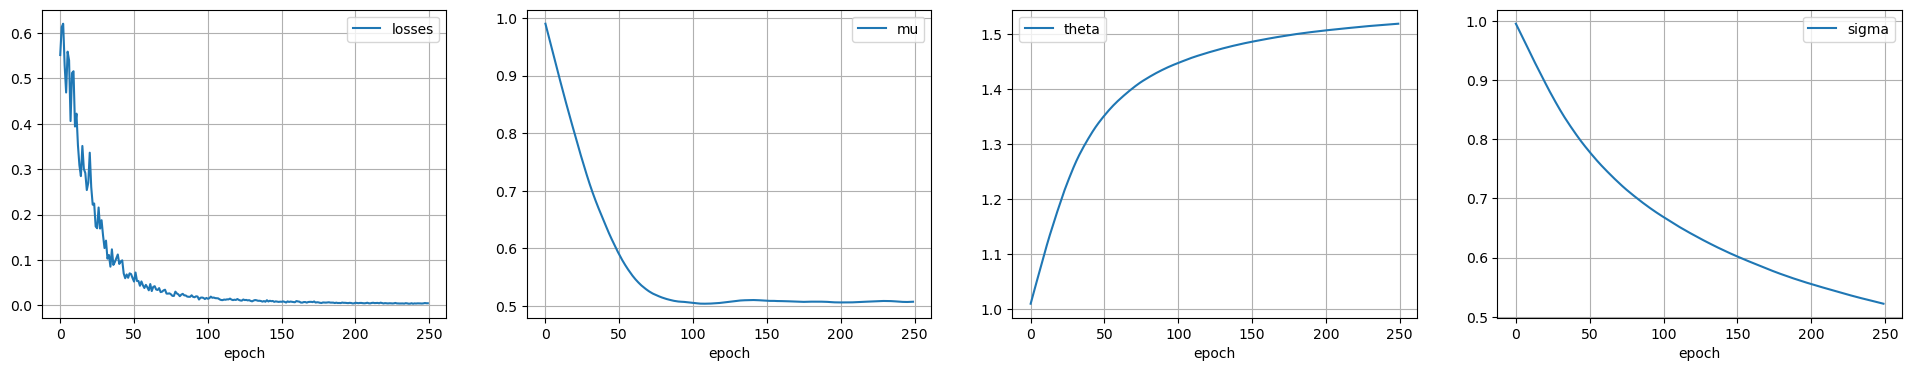

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24,4))

axs[0].plot(losses, label='losses')
axs[1].plot(mus, label='mu')
axs[2].plot(thetas, label='theta')
axs[3].plot(sigmas, label='sigma')

for i in range(4):
    axs[i].set_xlabel('epoch')
    axs[i].legend()
    axs[i].grid()

plt.show()

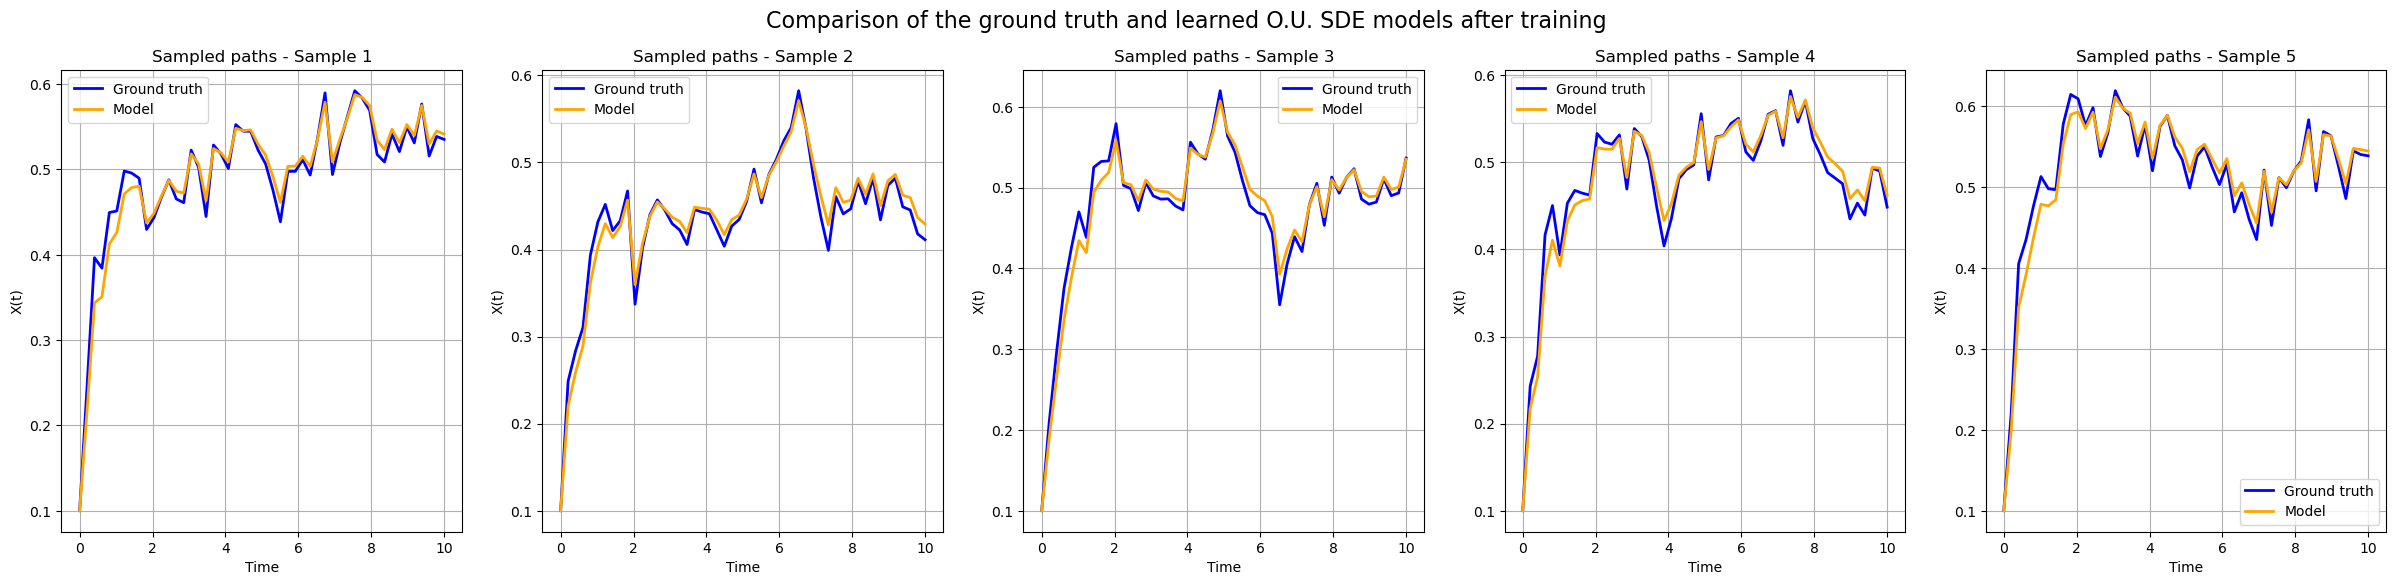

In [14]:
# now, we test the two models by sampling the SAME brownian motion for both
# after training
fig, ax = plot_comparison(model_ou_1)
fig.suptitle("Comparison of the ground truth and learned O.U. SDE models after training", fontsize=16)
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Toy 2 : learning a O.U. model from the data with bayesian inference
</div>

Here, we put a Gaussian prior on the O.U. paramters

In [15]:
class BayesianToy_OU_SDE(nn.Module):
    def __init__(self):
        
        # we keep "diagonal" noise type
        
        # sde_type can be "ito" or "stratonovich"
        # we use "ito" here. The available methods for computation are Euler(-Maruyama), Milstein, SRK.
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        # here, we want to learn the parameters theta, mu, sigma
        # we put a prior on them
        self.theta_mean = nn.Parameter(torch.tensor(1.0))  # initial guess
        self.theta_std = nn.Parameter(torch.tensor(0.5))   # initial guess
        self.mu_mean = nn.Parameter(torch.tensor(1.0))     # initial guess
        self.mu_std = nn.Parameter(torch.tensor(0.5))      # initial guess
        self.sigma_mean = nn.Parameter(torch.tensor(1.0))  # initial guess
        self.sigma_std = nn.Parameter(torch.tensor(0.5))   # initial guess

    # DRIFT FUNCTION
    def f(self, t, y):
        # sample parameters from normal distributions
        # NB : need the reparametrization trick to backprop through the sampling
        eps1 = torch.randn_like(self.theta_mean)
        self.theta = self.theta_mean + eps1 * torch.abs(self.theta_std)
        eps2 = torch.randn_like(self.mu_mean)
        self.mu = self.mu_mean + eps2 * torch.abs(self.mu_std)
        
        return self.theta * (self.mu - y)
    
    # DIFFUSION FUNCTION
    def g(self, t, y):
        # sample sigma from normal distribution with reparametrization trick
        eps3 = torch.randn_like(self.sigma_mean)
        self.sigma = self.sigma_mean + eps3 * torch.abs(self.sigma_std)

        return self.sigma**2 * torch.ones_like(y)

# instantiate model
bayesianmodel_ou = BayesianToy_OU_SDE().to(device)

In [16]:
N_PATHS = 10  # number of paths to sample

y_start = 0.25  # initial condition
y0 = torch.full((N_PATHS, 1), y_start).to(device)  # initial condition 0.25, shape (batch_size=N_PATHS, state_size=1)

preds = torchsde.sdeint(bayesianmodel_ou, y0, ts, method="euler", dt=1e-3)  # shape (N_POINTS, N_PATHS, 1)
print(f"Computed solution samples : {preds.size()}")

Computed solution samples : torch.Size([50, 10, 1])


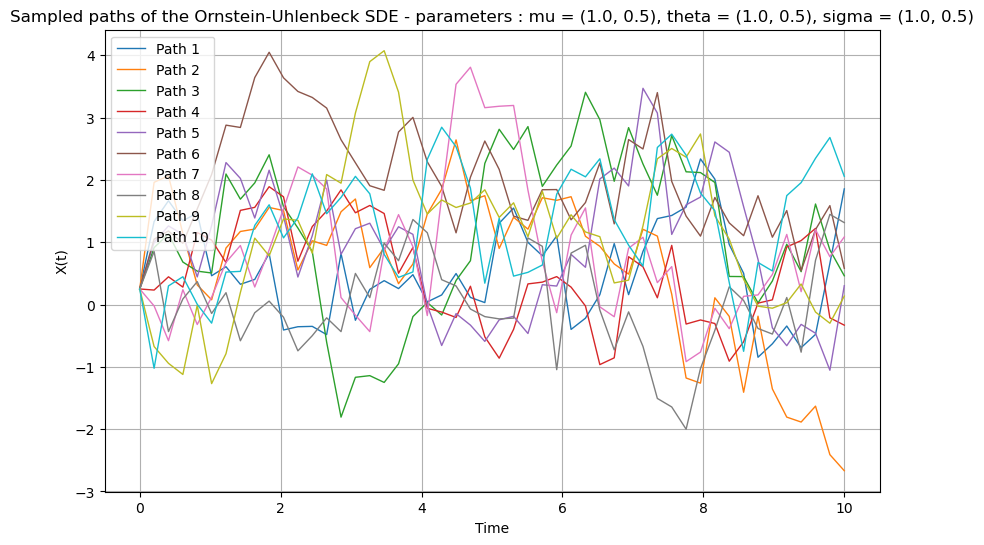

In [17]:
def plot_bayesian_ousde_samples(ts, ys, model):
    """
    Utility functions to plot the sampled SDE solutions
    """
    fig, ax = plt.subplots(figsize=(10,6))
    n_points = ts.size()[0]
    n_paths = ys.size()[1]
    
    for i, y in enumerate(ys.permute(1,0,2)):  # iterate over paths
        ax.plot(ts.detach().cpu().numpy(), y.detach().cpu().numpy(), lw=1, alpha=1.0, label=f'Path {i+1}' if i<10 else None)  # plot each path

    title = f"Sampled paths of the Ornstein-Uhlenbeck SDE - parameters : mu = ({model.mu_mean.item():.1f}, {model.mu_std.item():.1f})" \
        + f", theta = ({model.theta_mean.item():.1f}, {model.theta_std.item():.1f})" \
            + f", sigma = ({model.sigma_mean.item():.1f}, {model.sigma_std.item():.1f})"
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.legend()
    ax.grid()
        
    return fig, ax

fig, ax = plot_bayesian_ousde_samples(ts, preds, bayesianmodel_ou)
plt.show()

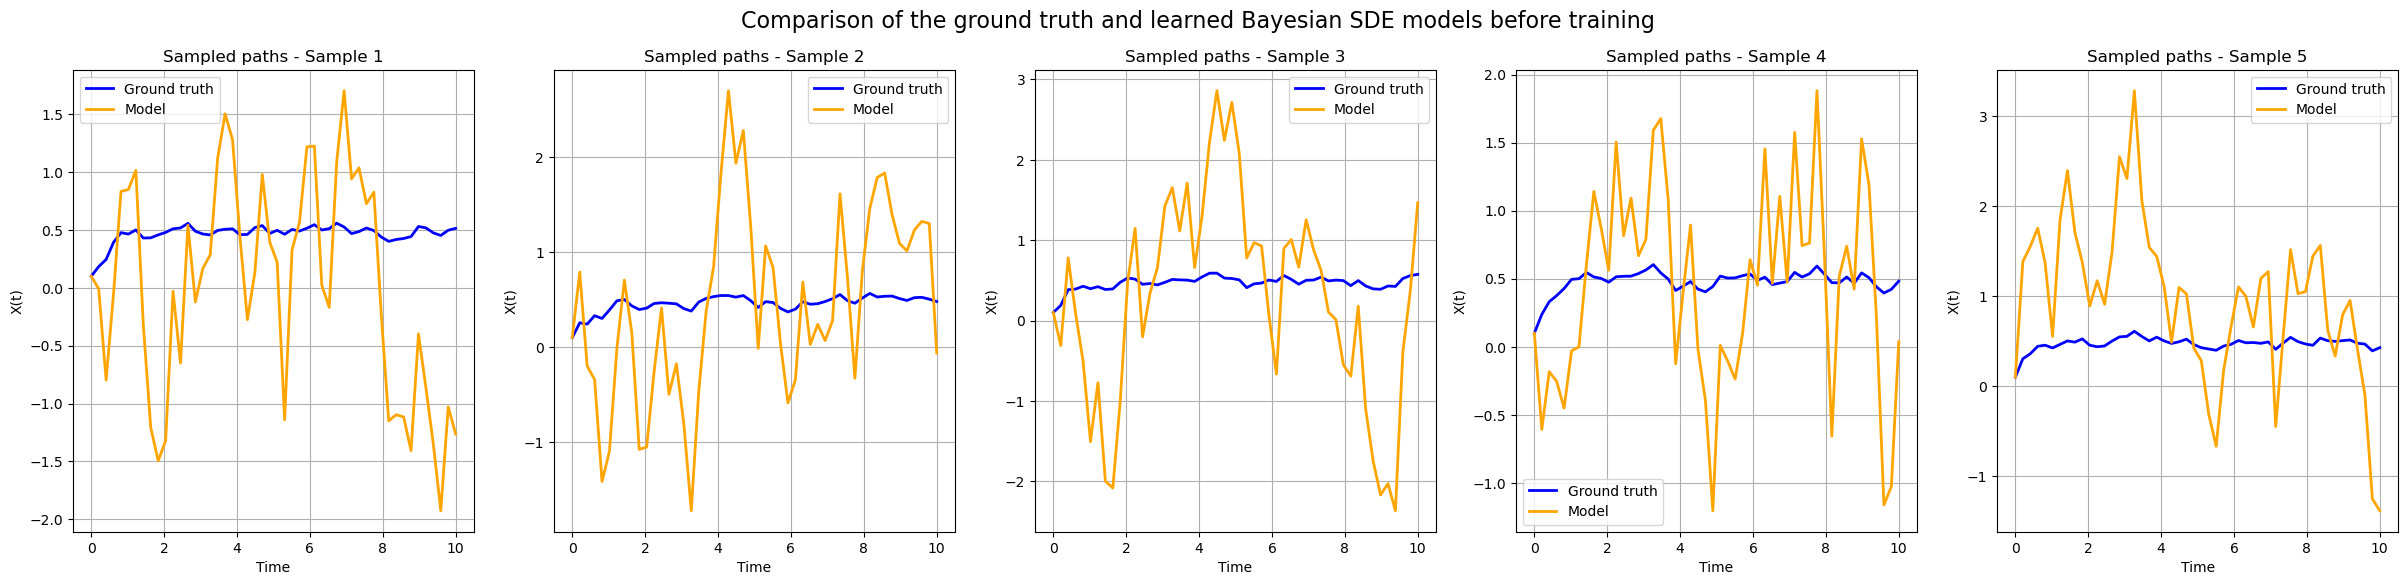

In [18]:
fig, ax = plot_comparison(bayesianmodel_ou)
fig.suptitle("Comparison of the ground truth and learned Bayesian SDE models before training", fontsize=16)
plt.show()

In [19]:
# training loop parameters
learning_rate = 1e-2

optimizer = torch.optim.Adam(
    list(bayesianmodel_ou.parameters()), 
    lr=learning_rate
)

print(f"Training for {N_EPOCHS} epochs with learning rate {learning_rate}")

losses = []
theta_priors = []
theta_stds = []
mu_priors = []
mu_stds = []
sigma_priors = []
sigma_stds = []

for epoch in range(N_EPOCHS):
    # compute SDE and sample N_PATHS
    preds = torchsde.sdeint(bayesianmodel_ou, y0, ts, method="euler", dt=1e-3)  # shape (N_POINTS, N_PATHS, 1)
    # compute average L2 loss between data paths and sampled paths
    mse = (data - preds.permute(1,0,2))**2
    loss = mse.mean()
    # train
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # record
    losses.append(loss.item())
    mm, ms = bayesianmodel_ou.mu_mean.item(), bayesianmodel_ou.mu_std.item()
    tm, t_s = bayesianmodel_ou.theta_mean.item(), bayesianmodel_ou.theta_std.item()
    sm, ss = bayesianmodel_ou.sigma_mean.item(), bayesianmodel_ou.sigma_std.item()
    mu_priors.append(mm)
    mu_stds.append(ms)
    theta_priors.append(tm)
    theta_stds.append(t_s)
    sigma_priors.append(sm)
    sigma_stds.append(ss)
    # report out
    print(f"Epoch {epoch+1:<3} - {N_EPOCHS:<3} - loss = {loss.item():.3e} - parametres : theta = ({tm:.3e}, {t_s:.3e}), mu = ({mm:.3e}, {ms:.3e}), sigma = ({sm:.3e}, {ss:.3e})")

Training for 250 epochs with learning rate 0.01
Epoch 1   - 250 - loss = 1.613e+00 - parametres : theta = (1.010e+00, 4.900e-01), mu = (9.900e-01, 4.900e-01), sigma = (9.900e-01, 4.900e-01)
Epoch 2   - 250 - loss = 1.605e+00 - parametres : theta = (1.020e+00, 4.805e-01), mu = (9.800e-01, 4.912e-01), sigma = (9.800e-01, 4.800e-01)
Epoch 3   - 250 - loss = 1.375e+00 - parametres : theta = (1.030e+00, 4.739e-01), mu = (9.701e-01, 4.968e-01), sigma = (9.700e-01, 4.702e-01)
Epoch 4   - 250 - loss = 1.379e+00 - parametres : theta = (1.040e+00, 4.700e-01), mu = (9.603e-01, 5.032e-01), sigma = (9.600e-01, 4.603e-01)
Epoch 5   - 250 - loss = 1.164e+00 - parametres : theta = (1.049e+00, 4.657e-01), mu = (9.510e-01, 5.107e-01), sigma = (9.501e-01, 4.506e-01)
Epoch 6   - 250 - loss = 9.341e-01 - parametres : theta = (1.059e+00, 4.594e-01), mu = (9.418e-01, 5.137e-01), sigma = (9.404e-01, 4.411e-01)
Epoch 7   - 250 - loss = 9.286e-01 - parametres : theta = (1.068e+00, 4.538e-01), mu = (9.328e-01, 5

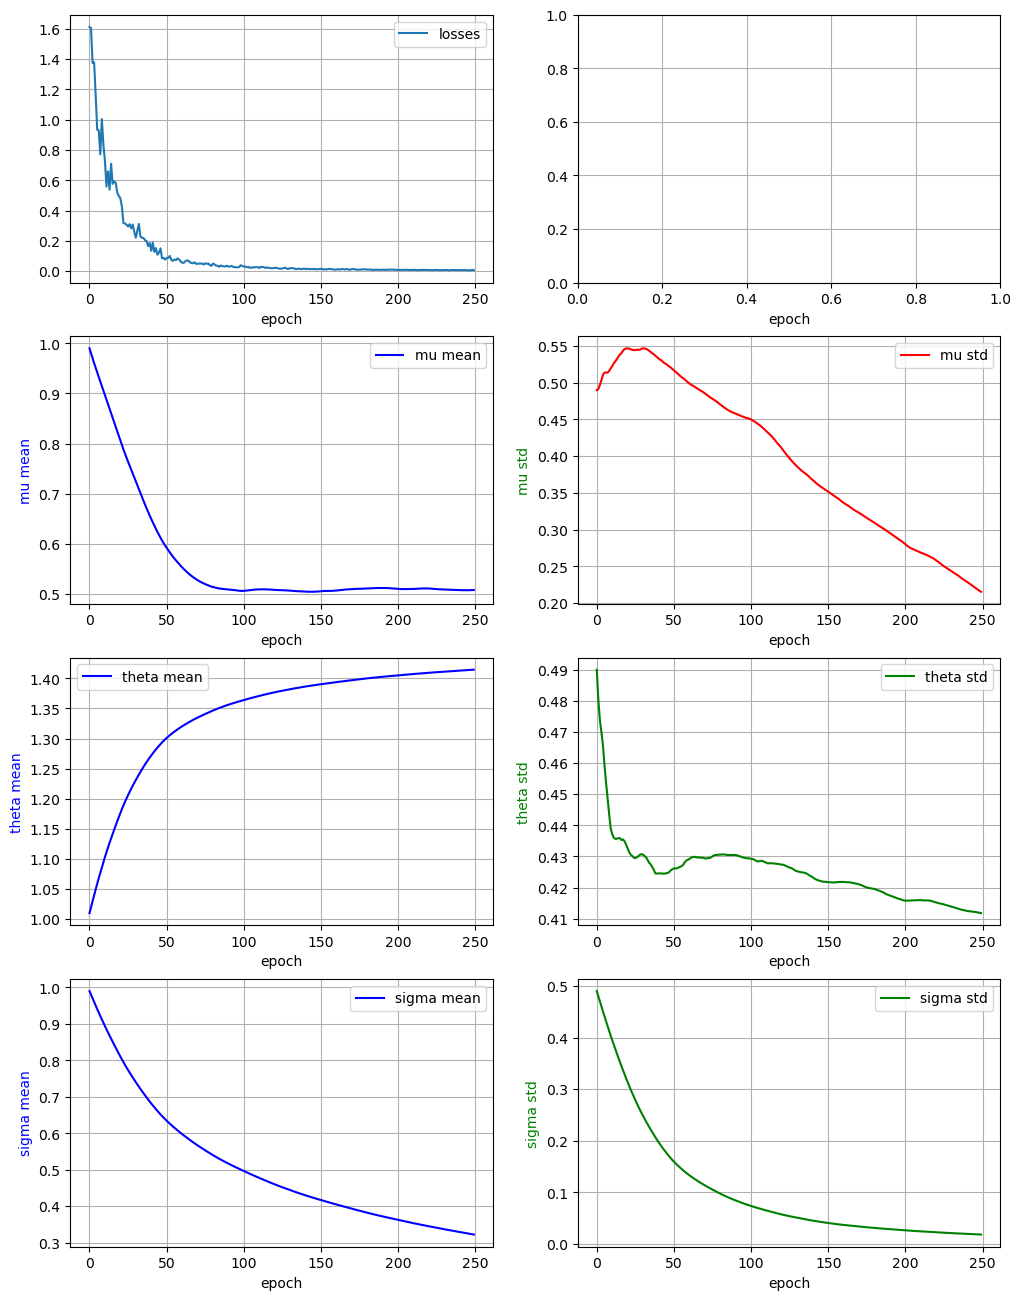

In [20]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,4*4))

axs[0, 0].plot(losses, label='losses')

# Second subplot - mu with two y-axes
axs[1, 0].plot(mu_priors, label='mu mean', color='blue')
axs[1, 1].plot(mu_stds, label='mu std', color='red')
axs[1, 0].set_ylabel('mu mean', color='blue')
axs[1, 1].set_ylabel('mu std', color='green')

# Third subplot - theta with two y-axes
axs[2, 0].plot(theta_priors, label='theta mean', color='blue')
axs[2, 0].set_ylabel('theta mean', color='blue')
axs[2, 1].plot(theta_stds, label='theta std', color='green')
axs[2, 1].set_ylabel('theta std', color='green')

# Fourth subplot - sigma with two y-axes
axs[3, 0].plot(sigma_priors, label='sigma mean', color='blue')
axs[3, 1].plot(sigma_stds, label='sigma std', color='green')
axs[3, 0].set_ylabel('sigma mean', color='blue')
axs[3, 1].set_ylabel('sigma std', color='green')

# Set common properties
for i in range(4):
    axs[i, 0].set_xlabel('epoch')
    axs[i, 1].set_xlabel('epoch')
    axs[i, 0].legend()
    if i > 0: axs[i, 1].legend()
    axs[i, 0].grid()
    axs[i, 1].grid()

plt.show()

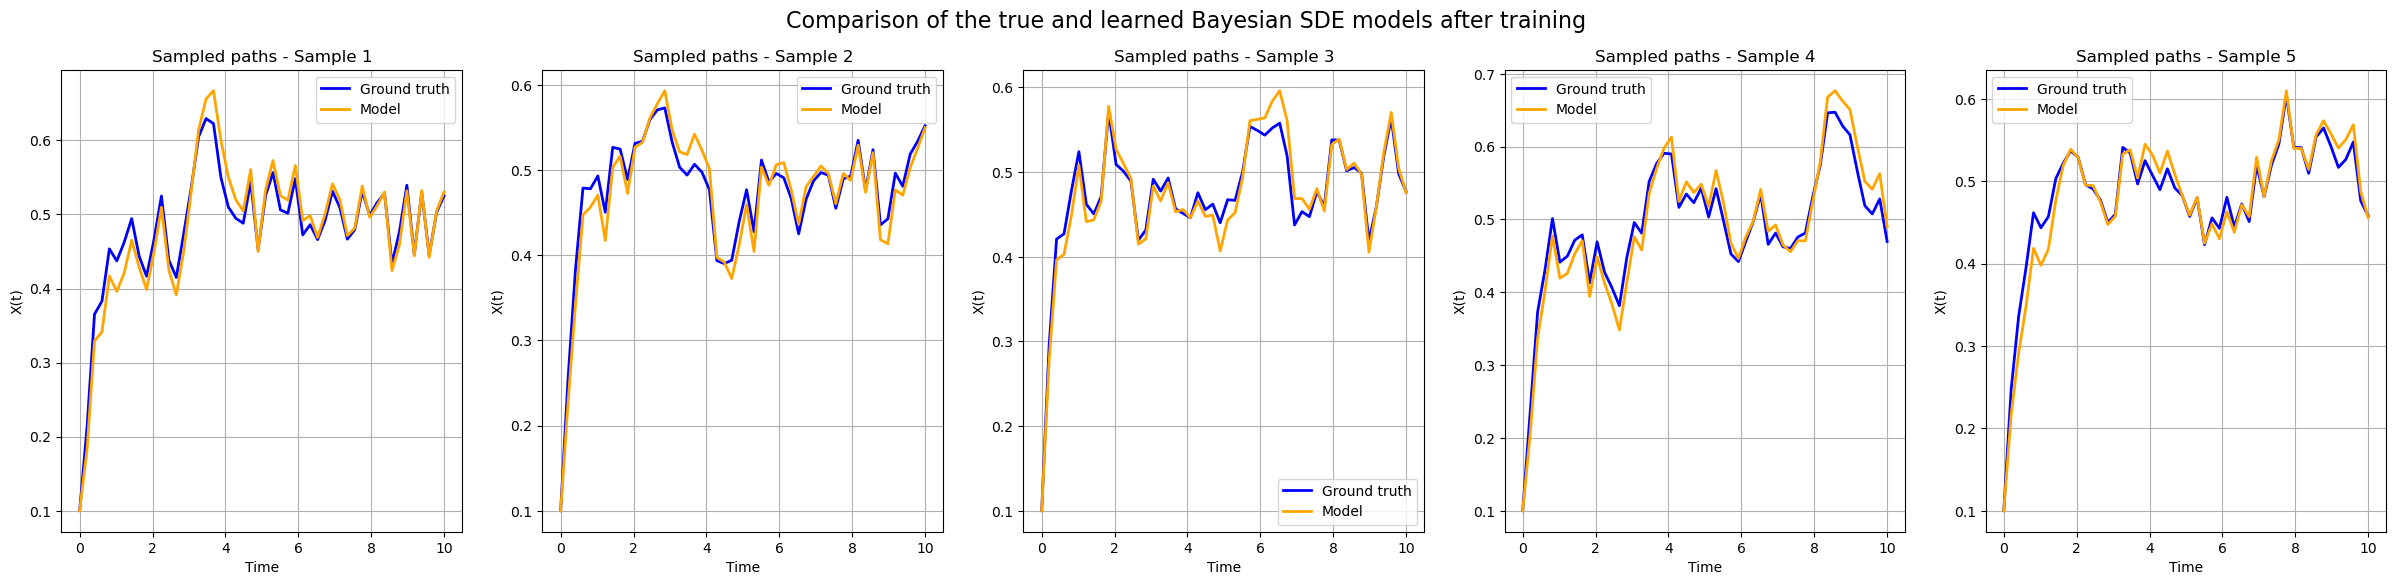

In [21]:
fig, ax = plot_comparison(bayesianmodel_ou)
fig.suptitle("Comparison of the true and learned Bayesian SDE models after training", fontsize=16)
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Toy 3 : learning an arbitrary SDE with a neural SDE model
</div>

Here, we sample paths from a non-trivial stochastic process, and learn drift and diffusion with MLPs

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Toy 4 : learning a latent SDE VAE model
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Model & Math
</div>

Data : $\mathbf{X} = (x_{t_1}, x_{t_2}, ..., x_{t_N}) \in \mathbb{R}^{D_x}$ - assuming all $t_i \in [0,1]$.

The latent space has dimension $D_z$. The latent continuous dynamic is $\mathbf{Z}$ defined by:
\begin{align*}
z_0^{(\theta)} &\sim p_{\theta_z}(z_0) \\
dz_t^{(\theta)} &= f_{\theta}(z_t, t)dt + \sigma_{\theta}(z_t,t)dB_t 
\end{align*}
with: 
\begin{align}
\textbf{drift} \,& f_{\theta} : \mathbb{R}^{D_z} \times [0,1] \rightarrow \mathbb{R}^{D_z} \\
\textbf{diffusion} \,& \sigma_{\theta} : \mathbb{R}^{D_z} \times [0,1] \rightarrow \mathbb{R}^{D_z \times D_z} \\
\textbf{Brownian motion} \,& dB_t \in \mathbb{R}^{D_z}
\end{align}

The decoder is classically:
\begin{align}
p_{\theta_x}(x_{t_i} \vert z_{t_i})
\end{align}

The approximate posterior (encoder) is also a SDE:
\begin{align}
z_0^{(\phi)} &\sim q_{\phi}(z_0 \vert \textbf{X}) \\
dz_t^{(\phi)} &= f_{\phi}(z_t, t, \textbf{X})dt + \sigma_{\theta}(z_t,t)dB_t 
\end{align}

where:
- the drift $f_{\phi}(z_t, t, \textbf{X})$ is conditionned on observations $\textbf{X}$
- the diffusion of the approximate posterior is shared with the diffusion of the prior : $\sigma_{\theta}(z_t,t)$ - this ensures the application of Girsanov theorem and a finite KL divergence between the two stochastic processes (prior and approximate posterior) (see Generative Modeling of Neural Dynamics via Latent Stochastic Differential Equations (https://arxiv.org/abs/2412.12112) (2024))
- drift and diffusion neural nets do not exhibit the same convergence guarantee (Stable Neural SDEs in analyzing irregular time series data (https://arxiv.org/abs/2402.14989) (2025))
- non-diagonal diffusion seems to be difficult to simulate and costly to approximate (Scalable Gradients for Stochastic Differential Equations (https://arxiv.org/abs/2001.01328) (2020))
- it seems a good practice to encode only part of the $\textbf{X}$ in the approximate posterior : context vector (Scalable Gradients for Stochastic Differential Equations (https://arxiv.org/abs/2001.01328) (2020)), and $t_c << t_n$ in Generative Modeling of Neural Dynamics via Latent Stochastic Differential Equations (https://arxiv.org/abs/2412.12112) (2024).

Variational lower bound on the log marginal likelihood:

We write:
\begin{align}
p(x_{t_1:t_N}) &= \frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{p(z_{t_1:t_N} \vert x_{t_1:t_N})}
\end{align}
And:
\begin{align}
\log{p(x_{t_1:t_N})} &= \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{q_{\phi}(z\vert X)}\frac{q_{\phi}(z\vert X)}{p(z_{t_1:t_N} \vert x_{t_1:t_N})}} dz
\end{align}
where $q_{\phi}(z \vert X)$ is formally is posterior distribution over **functions** $z : \mathbb{R} \rightarrow \mathbb{R}^{D_z}$.
Then:
\begin{align}
\log{p(x_{t_1:t_N})} &= \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{q_{\phi}(z\vert X)}} dz + \mathbb{KL}(q_{\phi}(z\vert X) \vert\vert p(z_{t_1:t_N} \vert x_{t_1:t_N}))
\end{align}
where we -audaciously- consider $p(z_{t_1:t_N} \vert x_{t_1:t_N})$ as a dsitribution over functions $z$ taking values $z_{t_1:t_N}$ at times $t_1:t_N$ so the $\mathbb{KL}$ actually means something.
Still on the same path:
\begin{align}
\log{p(x_{t_1:t_N})} &\geq \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{q_{\phi}(z\vert X)}} dz \\
&= \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N} \vert z_{t_1:t_N})}{q_{\phi}(z\vert X)} p(z_{t_1:t_N})} dz \\
&= \mathbb{E}_{q_{\phi}(z \vert X)} \log{p(x_{t_1:t_N} \vert z_{t_1:t_N})} - \mathbb{KL}(q_{\phi}(z\vert X) \vert\vert p(z_{t_1:t_N})) \\
\end{align}
We write -still audaciously-
\begin{align}
\mathbb{KL}(q_{\phi}(z\vert X) \vert\vert p(z_{t_1:t_N})) &= \mathbb{KL}(q_{\phi}(z_0\vert X) \vert\vert p_{\theta_z}(z_0)) + \mathbb{KL}(q_{\phi}(z_{>0}\vert X) \vert\vert p_{\theta_z}(z_{>0}))
\end{align}
where the first $\mathbb{KL}$ on the r.h.s is a classic between two probability distributions over a random variable, and the second is derived from the Girsanov's theorem as:
\begin{align}
\mathbb{KL}(q_{\phi}(z_{>0}\vert X) \vert\vert p_{\theta_z}(z_{>0})) &= \frac{1}{2} \mathbb{E}_{q_{\phi}(z_{>0}\vert X)} \left( \int_{0}^{T} \vert \Delta(t) \vert^2 dt \right) \\
\Delta(t) &= \sigma_{\theta}^{-1}(z_t,t) (f_{\phi}(z_t, t, \textbf{X}) - f_{\theta}(z_t, t))
\end{align}

Finally:
\begin{align}
\mathcal{L}(\theta, \phi, \textbf{X}) &= \mathbb{E}_{q_{\phi}(z \vert X)} \log{p(x_{t_1:t_N} \vert z_{t_1:t_N})} - \mathbb{KL}(q_{\phi}(z_0\vert X) \vert\vert p_{\theta_z}(z_0)) - \frac{1}{2} \mathbb{E}_{q_{\phi}(z_{>0}\vert X)} \left( \int_{0}^{T} \vert \Delta(t) \vert^2 dt \right)
\end{align}

During training:
- the integral is approximated via numerical integration
- expectations are estimated with MC sampling
- NB : sampling is actually : sampling $z_0 \sim q_{\phi}(z_0 \vert \textbf{X})$ and sampling a function $z$ by sampling a Brownian motion path $B_t$ and computing the whole realization path $z_t$.